In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.datasets import sunspots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

In [ ]:
data = sunspots.load_pandas().data

In [ ]:
data

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
...,...,...
304,2004.0,40.4
305,2005.0,29.8
306,2006.0,15.2
307,2007.0,7.5


In [ ]:
data.describe()

,YEAR,SUNACTIVITY
count,309.000000,309.000000
mean,1854.000000,49.752104
std,89.344838,40.452595
min,1700.000000,0.000000
25%,1777.000000,16.000000
50%,1854.000000,40.000000
75%,1931.000000,69.800000
max,2008.000000,190.200000


In [ ]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   YEAR         309 non-null    float64
 1   SUNACTIVITY  309 non-null    float64
dtypes: float64(2)
memory usage: 5.0 KB


In [ ]:
data['YEAR'] = data['YEAR'].astype(int)

In [ ]:
data

,YEAR,SUNACTIVITY
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0
...,...,...
304,2004,40.4
305,2005,29.8
306,2006,15.2
307,2007,7.5


preparing the data

In [ ]:
data.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del data["YEAR"]

In [ ]:
data

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0
...,...
2004-12-31,40.4
2005-12-31,29.8
2006-12-31,15.2
2007-12-31,7.5


examining the data

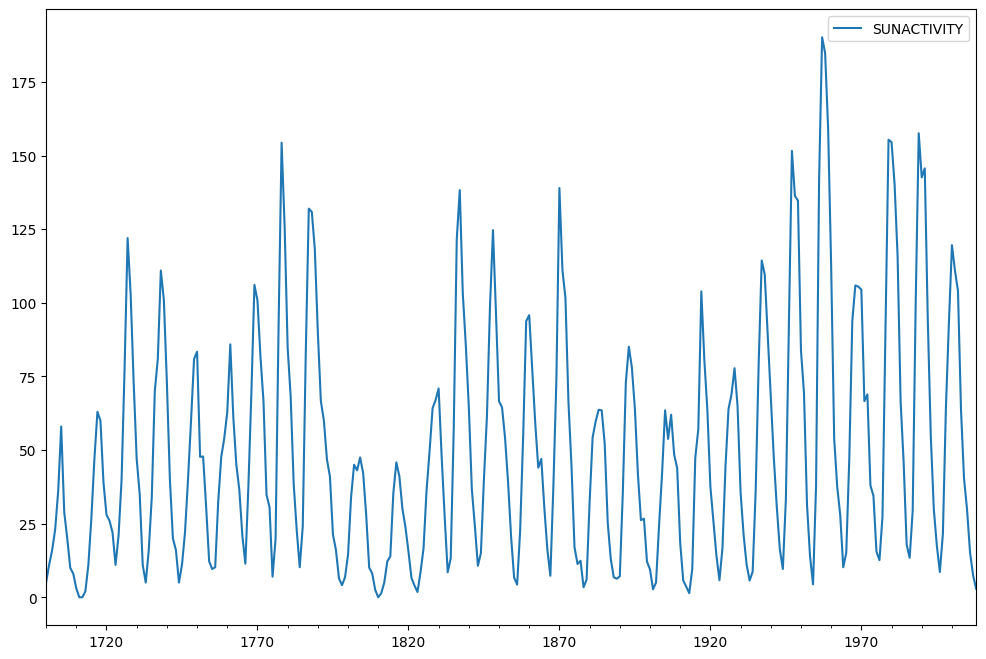

In [ ]:
# show plots in the notebook
%matplotlib inline
data.plot(figsize=(12,8));

In [ ]:
sm.stats.durbin_watson(data) ## to check autocorreation
#not close to 2 so there is strong correlation

array([0.13952893])

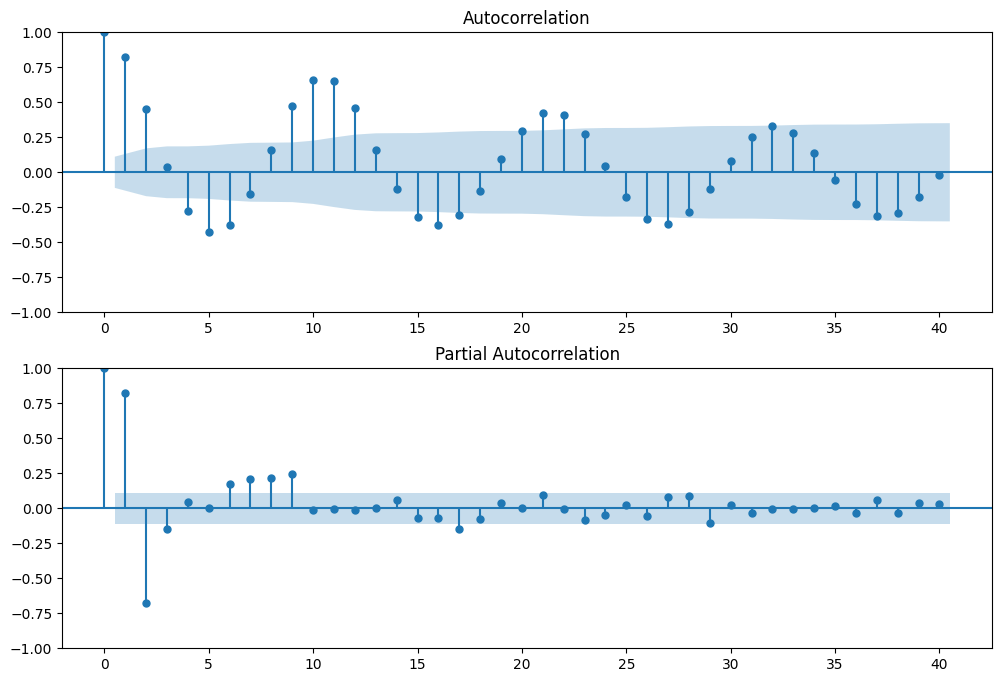

In [ ]:
# show plots in the notebook
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax2)

In a SARIMA model, the ACF displays a mixture of exponentials and dampened sine waves for both non-seasonal and seasonal lags, while the PACF exhibits similar patterns after accounting for the order of non-seasonal and seasonal components.

In a SARIMA model, both the non-seasonal (p, q) and seasonal (P, Q) orders are considered to capture the overall autocorrelation and moving average structures, which are then modified by the seasonality (s).

**modelling the data**

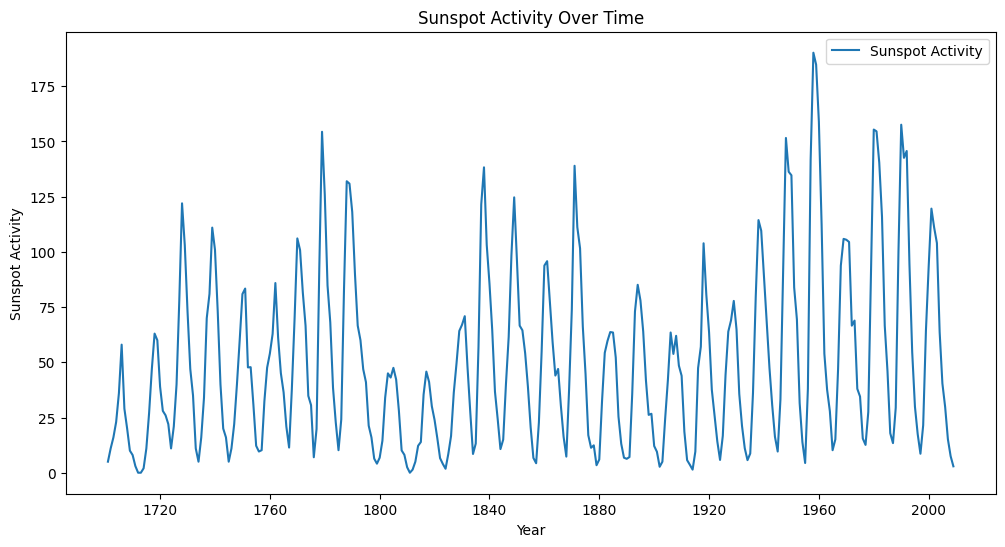

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['SUNACTIVITY'], label='Sunspot Activity')
plt.xlabel('Year')
plt.ylabel('Sunspot Activity')
plt.title('Sunspot Activity Over Time')
plt.legend()
plt.show()


In [ ]:
# Define the SARIMA model
order = (2, 0, 0)  # Non-seasonal order (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Seasonal order (P, D, Q, s)


In [ ]:
sarima_model = SARIMAX(data['SUNACTIVITY'], order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


taking annual frequency by default as per the data- "A-DEC" stands for "Annual, December frequency.

In [ ]:
print(sarima_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          SUNACTIVITY   No. Observations:                  309
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 12)   Log Likelihood               -1274.841
Date:                              Thu, 12 Oct 2023   AIC                           2559.682
Time:                                      03:25:16   BIC                           2578.151
Sample:                                  12-31-1700   HQIC                          2567.076
                                       - 12-31-2008                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3352      0.036     37.488      0.000       1.265       1.405
ar.L2         -0.64

In [ ]:
print(sarima_results.aic, sarima_results.bic, sarima_results.hqic)

2559.6823954511265 2578.15105614514 2567.076054901508


In [ ]:
# Calculate the Durbin-Watson statistic for residual autocorrelation
durbin_watson_statistic = sm.stats.durbin_watson(sarima_results.resid.values)
print(f"Durbin-Watson Statistic: {durbin_watson_statistic}")


Durbin-Watson Statistic: 2.0004287177995064


In [ ]:
predict_sunspots20 = sarima_results.predict('1990', '2012', dynamic=False)
print(predict_sunspots20)

1990-12-31    171.900805
1991-12-31    112.586308
1992-12-31    118.261701
1993-12-31     51.282129
1994-12-31     27.893381
1995-12-31     17.755519
1996-12-31     22.788814
1997-12-31     10.513219
1998-12-31     34.620117
1999-12-31     85.636977
2000-12-31    109.555732
2001-12-31    121.144055
2002-12-31     84.152378
2003-12-31     93.985924
2004-12-31     30.276074
2005-12-31     30.635083
2006-12-31     27.986573
2007-12-31     15.990235
2008-12-31     13.550011
2009-12-31     13.607296
2010-12-31     32.785535
2011-12-31     48.664924
2012-12-31     64.999350
Freq: A-DEC, Name: predicted_mean, dtype: float64


The predict method is used to forecast values, and the dynamic parameter controls whether previously predicted values are used to predict subsequent values.

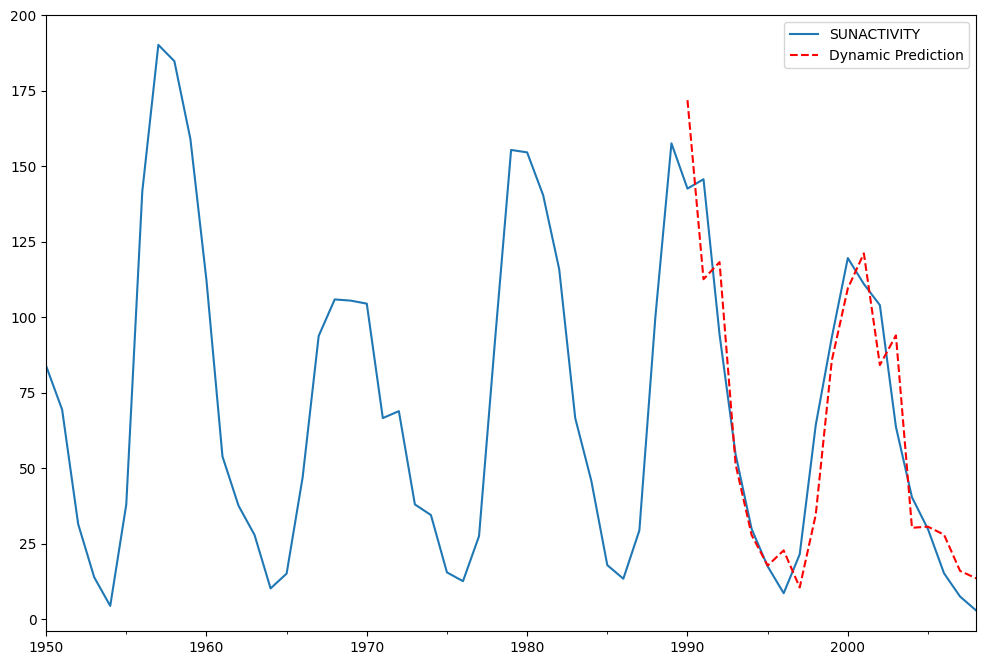

In [ ]:
ax = data.loc['1950':].plot(figsize=(12,8))
ax = predict_sunspots20.plot(ax=ax, style='r--', label='Dynamic Prediction');
ax.legend();
ax.axis((-20.0, 38.0, -4.0, 200.0));

The fit looks good up to about 1998 and underfit the data afterwards. // should change this
Calculate Forecast Errors
Mean absolute error:

The mean absolute error (MAE) value is computed as the average absolute error value. If this value is 0 (zero), the fit (forecast) is perfect. As compared to the mean squared error value, this measure of fit will “de-emphasize” outliers, that is, unique or rare large error values will affect the MAE less than the MSE value.
Mean Forecast Error (Bias).

The mean forecast error (MFE) is the average error in the observations. A large positive MFE means that the forecast is undershooting the actual observations, and a large negative MFE means the forecast is overshooting the actual observations. A value near zero is ideal.
The MAE is a better indicator of fit than the MFE.

In [ ]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat)) # or percent error = * 100

In [ ]:
print("MFE = ", mean_forecast_err(data.SUNACTIVITY, predict_sunspots20))
print("MAE = ", mean_absolute_err(data.SUNACTIVITY, predict_sunspots20))

MFE =  -0.7428965297288692
MAE =  0.0236422077632091


For MFE > 0, models tends to under-forecast. However, as long as the tracking signal is between –4 and 4, we assume the model is working correctly. The measure of MAE being small would indicate a pretty good fit.
We can see that our MFE is close to -1, inferring that it is a good fit.